# Spanish to Engish:  Machine Translation

In [36]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


## 1. Imports

In [37]:
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

## 2. Data Preparation

In [38]:
# Path to translation file
path_to_data = '/content/drive/MyDrive/Datasets/spanish/spa.txt'

# Read file
translation_file = open(path_to_data,"r", encoding='utf-8')
raw_data = translation_file.read()
translation_file.close()

# Parse data
raw_data = raw_data.split('\n')
pairs = [sentence.split('\t') for sentence in  raw_data]

In [39]:
len(pairs)
data_paris = pairs[:141367]

Text Cleaning

In [40]:
def clean_sentence(sentence):
    # Lower case the sentence
    lower_case_sent = sentence.lower()
    # Strip punctuation
    string_punctuation = string.punctuation + "¡" + '¿'
    clean_sentence = lower_case_sent.translate(str.maketrans('', '', string_punctuation))

    return clean_sentence

Next, we tokenize the sentences and analyse the data.

In [41]:
def tokenize(sentences):
    # Create tokenizer
    text_tokenizer = Tokenizer()

    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

Once we are done with creating the functions we can do the pre-processing:

In [42]:
# Clean sentences
english_sentences = [clean_sentence(pair[0]) for pair in data_paris]
spanish_sentences = [clean_sentence(pair[1]) for pair in data_paris]

# Tokenize words
spa_text_tokenized, spa_text_tokenizer = tokenize(spanish_sentences)
eng_text_tokenized, eng_text_tokenizer = tokenize(english_sentences)

print('Maximum length spanish sentence: {}'.format(len(max(spa_text_tokenized,key=len))))
print('Maximum length english sentence: {}'.format(len(max(eng_text_tokenized,key=len))))


# Check language length
spanish_vocab = len(spa_text_tokenizer.word_index) + 1
english_vocab = len(eng_text_tokenizer.word_index) + 1

print("Spanish vocabulary is of {} unique words".format(spanish_vocab))
print("English vocabulary is of {} unique words".format(english_vocab))

Maximum length spanish sentence: 44
Maximum length english sentence: 43
Spanish vocabulary is of 28294 unique words
English vocabulary is of 14504 unique words


We apply padding to make the maximum length of the sentences in each language equal.

In [43]:
max_spanish_len = int(len(max(spa_text_tokenized,key=len)))
max_english_len = int(len(max(eng_text_tokenized,key=len)))

spa_pad_sentence = pad_sequences(spa_text_tokenized, max_spanish_len, padding = "post")
eng_pad_sentence = pad_sequences(eng_text_tokenized, max_english_len, padding = "post")

# Reshape data
spa_pad_sentence = spa_pad_sentence.reshape(*spa_pad_sentence.shape, 1)
eng_pad_sentence = eng_pad_sentence.reshape(*eng_pad_sentence.shape, 1)

In [44]:
spa_pad_sentence.shape

(141367, 44, 1)

In [45]:
eng_pad_sentence.shape

(141367, 43, 1)

In [46]:
from sklearn.model_selection import train_test_split
spa_train, spa_test, eng_train, eng_test = train_test_split(spa_pad_sentence, eng_pad_sentence, test_size=0.2, random_state=42)

In [47]:
print(spa_train.shape)
print(spa_test.shape)
print(eng_train.shape)
print(eng_test.shape)

(113093, 44, 1)
(28274, 44, 1)
(113093, 43, 1)
(28274, 43, 1)


## 3. Model Development

### a. Encoder
![image](https://miro.medium.com/v2/resize:fit:640/format:webp/1*7eMDChm9Q-VR3ZpMWY7N8w.png)

### b. Decoder
![image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*n6AK9f09yZQdvC2c7P5LNQ.png)

In [48]:
# Encoder
input_sequence = Input(shape=(max_spanish_len,))
embedding = Embedding(input_dim=spanish_vocab, output_dim=128,)(input_sequence)
encoder = LSTM(64, return_sequences=False)(embedding)

# Decoder
r_vec = RepeatVector(max_english_len)(encoder)
decoder = LSTM(64, return_sequences=True, dropout=0.2)(r_vec)
logits = TimeDistributed(Dense(english_vocab))(decoder)
last = Activation('softmax')(logits)

In [49]:
enc_dec_model = Model(input_sequence, last)
enc_dec_model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(1e-3), metrics=['accuracy'])
enc_dec_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 44)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 44, 128)           3621632   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 43, 64)            0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 43, 64)            33024     
                                                                 
 time_distributed_1 (TimeDi  (None, 43, 14504)         942760    
 stributed)                                                

In [51]:
model_results = enc_dec_model.fit(spa_train, eng_train, batch_size=64, epochs=10, validation_data=(spa_test, eng_test))

Epoch 1/10
1768/1768 [==============================] - 102s 57ms/step - loss: 1.0036 - accuracy: 0.8604 - val_loss: 0.9833 - val_accuracy: 0.8616
Epoch 2/10
1768/1768 [==============================] - 91s 51ms/step - loss: 0.9809 - accuracy: 0.8614 - val_loss: 0.9782 - val_accuracy: 0.8616
Epoch 3/10
1768/1768 [==============================] - 89s 50ms/step - loss: 0.9765 - accuracy: 0.8615 - val_loss: 0.9772 - val_accuracy: 0.8616
Epoch 4/10
1768/1768 [==============================] - 91s 51ms/step - loss: 0.9742 - accuracy: 0.8614 - val_loss: 0.9766 - val_accuracy: 0.8616
Epoch 5/10
1768/1768 [==============================] - 81s 46ms/step - loss: 0.9725 - accuracy: 0.8614 - val_loss: 0.9761 - val_accuracy: 0.8616
Epoch 6/10
1768/1768 [==============================] - 90s 51ms/step - loss: 0.9713 - accuracy: 0.8614 - val_loss: 0.9763 - val_accuracy: 0.8616
Epoch 7/10
1768/1768 [==============================] - 91s 51ms/step - loss: 0.9311 - accuracy: 0.8631 - val_loss: 0.9051 

Plot the accuracy

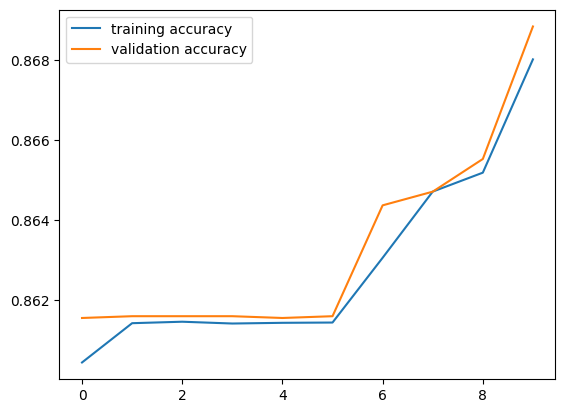

In [52]:
import matplotlib.pyplot as plt

plt.plot(model_results.history["accuracy"], label="training accuracy")
plt.plot(model_results.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

Plot the loss

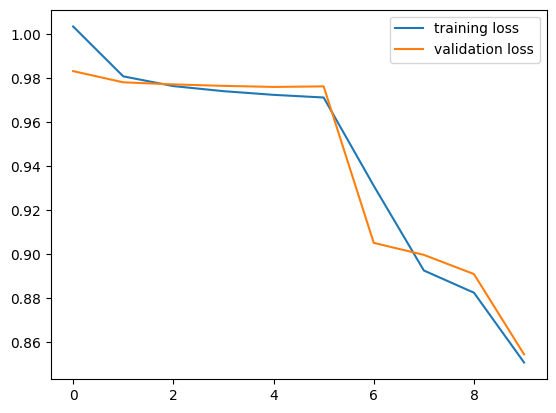

In [53]:
plt.plot(model_results.history["loss"], label="training loss")
plt.plot(model_results.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [54]:
y_pred = enc_dec_model.evaluate(spa_test, eng_test)

884/884 [==============================] - 21s 24ms/step - loss: 0.8543 - accuracy: 0.8688


In [79]:
def logits_to_sentence(logits, tokenizer):

    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

index = 34534
print("The english sentence is: {}".format(english_sentences[index]))
print("The spanish sentence is: {}".format(spanish_sentences[index]))
print('The predicted sentence is :')
print(logits_to_sentence(enc_dec_model.predict(spa_pad_sentence[index:index+1])[0], eng_text_tokenizer))

The english sentence is: i have to dry my hair
The spanish sentence is: me tengo que secar el pelo
The predicted sentence is :
1/1 [==============================] - 0s 59ms/step
i you to a the <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty> <empty>


The result is not good because we did not train the model enough due to time constraint. Here, our focus is how to implement the architecture not performance.